In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('datasets/controllable_sampled.csv', index_col = 'id')

## Building a baseline LR model using all "controllable" features

In [3]:
X_train0, X_test0, Y_train0, Y_test0 = train_test_split(df.drop('Label', 1), df.Label, test_size = 0.2, random_state = 42)

scaler = StandardScaler().fit(X_train0)
X_train_scaled0 = pd.DataFrame(scaler.transform(X_train0), columns = df.drop('Label', 1).columns)
X_test_scaled0 = pd.DataFrame(scaler.transform(X_test0), columns = df.drop('Label', 1).columns)

In [4]:
lr0 = linear_model.LogisticRegression(max_iter = 2000, solver = 'saga')
lr0.fit(X_train_scaled0, Y_train0)
Y_pred = lr0.predict_proba(X_test_scaled0)[:,1]

fpr_lr0, tpr_lr0, thresholds_lr0 = metrics.roc_curve(Y_test0, Y_pred)
auc_lr0 = metrics.auc(fpr_lr0, tpr_lr0)
acc_lr0 = np.mean(np.abs(Y_test0 - Y_pred))

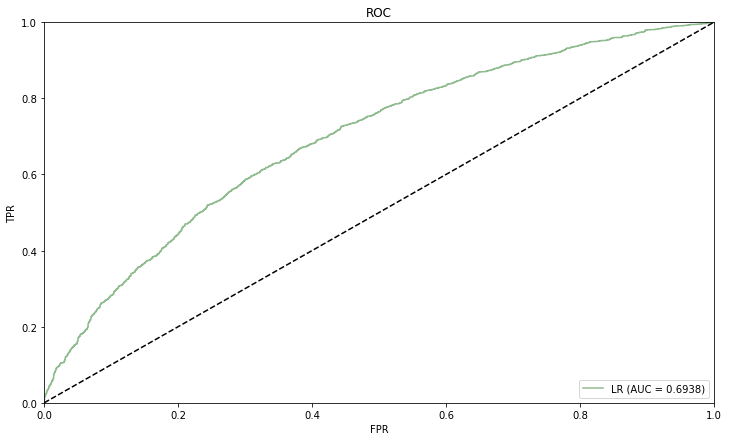

In [5]:
fig = plt.figure(figsize = (12,7))

plt.plot(fpr_lr0, tpr_lr0, color = "darkseagreen", label = "LR (AUC = {:0.4f})".format(auc_lr0))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc = 'lower right')

plt.show()

In [6]:
print('Baseline LR model accuracy = {:.4f}'.format(acc_lr0))

Baseline LR model accuracy = 0.4432


### Hyperparameter selection

In [15]:
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameters over which to search
param_grid = [
    {'C': np.logspace(-5, 5, num = 1000), 
     'penalty': ['l1', 'l2'],
    'solver': ['saga'],
    'max_iter': [2000]}
]

scores = ['roc_auc', 'accuracy']

lr_RS = RandomizedSearchCV(linear_model.LogisticRegression(), param_distributions = param_grid, scoring = scores, 
                     cv = 5, refit = scores[0], n_jobs = -1, random_state = 42)
lr_RS.fit(X_train_scaled0, Y_train0)

RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
                   param_distributions=[{'C': array([1.00000000e-05, 1.02331658e-05, 1.04717682e-05, 1.07159340e-05,
       1.09657929e-05, 1.12214777e-05, 1.14831241e-05, 1.17508713e-05,
       1.20248614e-05, 1.23052400e-05, 1.25921561e-05, 1.28857621e-05,
       1.31862140e-05, 1.34936714e-05, 1.38082977e-05, 1.41302599e-05,
       1.44597292e-...
       7.07701066e+04, 7.24202233e+04, 7.41088152e+04, 7.58367791e+04,
       7.76050334e+04, 7.94145172e+04, 8.12661920e+04, 8.31610415e+04,
       8.51000725e+04, 8.70843150e+04, 8.91148232e+04, 9.11926760e+04,
       9.33189772e+04, 9.54948564e+04, 9.77214697e+04, 1.00000000e+05]),
                                         'max_iter': [2000],
                                         'penalty': ['l1', 'l2'],
                                         'solver': ['saga']}],
                   random_state=42, refit='roc_auc',
                   scoring=['roc_auc', 'accuracy']

In [16]:
lr_RS.best_params_

{'solver': 'saga', 'penalty': 'l1', 'max_iter': 2000, 'C': 0.20151357338155584}

In [17]:
print("AUC of best performing model: {:.5f}".format(lr_RS.best_score_))

AUC of best performing model: 0.68852
